# 5. 사람이 말하는 단어를 인공지능 모델로 구분해보자

#  Spectrogram classification 모델 구현

 앞써 1차원 Waveform데이터를 입력받아 기본모델과 Skip-conection모델 학습시켰다.   
 2차원 Spectrogram 데이터를 입력받아 기본모델과 Skip-conecttion모델로 진행해보자.

# 순서

#### 0. 음성 wav 파일 다운로드 및 살펴보기
 - wav파일 간단히 살펴보기
 
#### 1. 데이터 처리와 분류
  - 라벨 데이터 처리하기
  - sklearn의 train_test_split함수를 이용하여 train, test 분리   
  
#### 2. 학습을 위한 하이퍼파라미터 설정  
#### 3. 데이터셋 구성
  - tf.data.Dataset을 이용
  - from_tensor_slices 함수
  - map과 batch를 이용한 데이터 전처리( 메모리 부족 현상 주의! )
  - wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워주자.
  - del speech_data / del spec_data

#### 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성
  - 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능
  - batchnorm, dropout, dense layer 등을 이용
  - 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
  - 모델 가중치를 저장하는 checkpoint callback 함수 추가
  - 다양한 모델의 실험을 진행해 보시기 바랍니다.

#### 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력
  - loss, accuracy를 그래프로 표현


#### 6. Test dataset을 이용해서 모델의 성능을 평가
  - 저장한 weight 불러오기
  - 모델의 예측값과 정답값이 얼마나 일치하는지 확인


```
```

# 0.음성 wav 파일 다운로드 및 살펴보기

### wav 파일  
1차원으로 이루어진 시계열 데이터이다. 여러소리파형이 합쳐진 복합파이다.    
 
### Bits per sample 
 샘플 하나마다 소리의 세기를 몇 비트 구성   
 16bit라면 소리의 세기를 2이 16승=65,536단계로 표현.   
 값이 커질 수록 세기를 정확하게 저장   
 
### Sampling frequency 
샘플링 주파수라는 단어입니다. 소리로부터 초당 샘플링한 횟수를 의미합니다.
 
### Channel   
각 채널별로 샘플링된 데이터가 따로 저장됨   
2채널(Stereo): 왼쪽(L)과 오른쪽(R) 스피커에 다른 값이 출력.   
1채널(Mono) : 왼쪽(L) 데이터 존재, 재생시 왼쪽(L)과 오른쪽(R)에 같은 값이 출력   


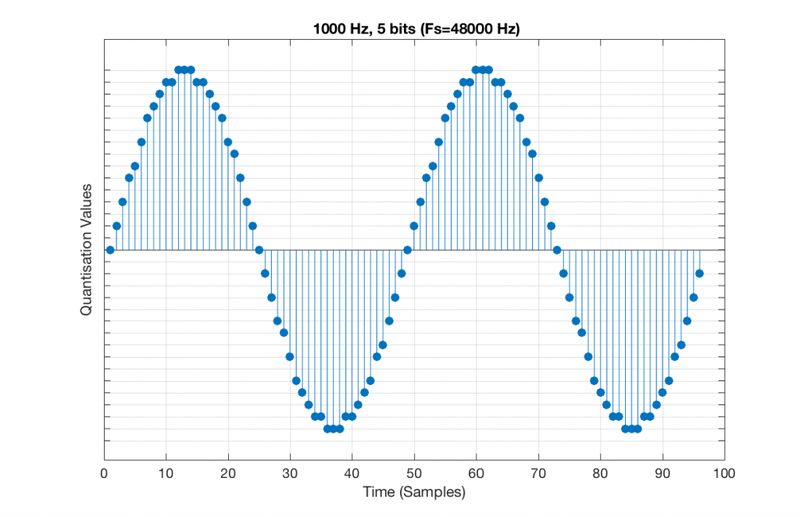

1000 Hz 신호를 저장한 wav 파일입니다.   
Sample rate 는 48000 Hz, 즉 1초 재생하는데 필요한 Sample 수는 48000개입니다.    
모든 샘플은 -1 ~ 1 사이의 정해진 bits per sample의 값으로 표현됩니다.
   
```
HZ로 표현되는 주파수는 초당 클럭수이다.(1주기)
한번 반복을 클럭(clock) 이라고한다.
sampling rate은 초당 샘플링의 횟수를 말합니다.
 
```

# 음성데이터 다운로드    
(주의 : 1.6GB의 대용량 데이터입니다. 다운로드에 시간이 오래걸릴 수 있으니 주의해 주세요.)

```
$ mkdir -p ~/aiffel/speech_recognition/data
$ mkdir -p ~/aiffel/speech_recognition/models
$ wget https://aiffelstaticdev.blob.core.windows.net/dataset/speech_wav_8000.npz -P ~/aiffel/speech_recognition/data

```

```
```

# 1. 데이터 처리와 분류

#### speech_data : 데이터경로로 데이터 받기

In [9]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)# np.load()함수로 npz파일 열어 배열로 불러온다.

print("✅")

✅


#### speech_data["wav_vals"]: 50620개의 각각의 음성 데이터는 8000개(sampling rate)로 표현   

#### speech_data["label_vals"] : 라벨 데이터  


In [10]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)
print("✅")

print('speech_data타입:',type(speech_data))
print('speech_data["wav_vals"]타입:',type(speech_data["wav_vals"]))

print("wav총사이즈: ",speech_data["wav_vals"].size) # 50620 x 8000
print("wav차원수: ",speech_data["wav_vals"].ndim) #2차원

print("label총사이즈:",speech_data["label_vals"].size) # 50620 x 8000
print("label차원수",speech_data["label_vals"].ndim)
print(len(speech_data["wav_vals"]))

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)
✅
speech_data타입: <class 'numpy.lib.npyio.NpzFile'>
speech_data["wav_vals"]타입: <class 'numpy.ndarray'>
wav총사이즈:  404960000
wav차원수:  2
label총사이즈: 50620
label차원수 2
50620


    
#### 랜덤으로 음성 데이터 뽑아오기
```
speech_data["wav_vals"][0 ~ 50619 ]

   0 ~ 2151  : down     / 2151개
2152 ~ 4252  : go       / 2100개 
4253 ~ 6417  : left     / 2164개
     ....
     ~50619  : silence  / ????개     

```

In [11]:
import IPython.display as ipd
import random


# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]

#data는 8000개로샘플링된 음성데이터
#print("data.shape : ", data.shape) 
#(8000,0)출력

#rand숫자에 대한 라벨 
print("label : ", speech_data["label_vals"][rand]) 


#for  i in range(50619,50620):
#print(i, speech_data["label_vals"][i])


ipd.Audio(data, rate=sr)

rand num :  1762
label :  ['down']


   
####  label 목록 만들기

```
    label_value 타입 :  리스트 -> 딕셔너리
new_label_value 타입 :  딕셔너리
    
    {'텍스트': 숫자}
    {'yes ~ silence' : 0 ~ 11}

``` 

In [12]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)# 밑 코드에서 label_value 딕셔너리로 바꿈

new_label_value = dict()
for i, l in enumerate(label_value): # i 라벨목록값, l 인덱스값
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)
#label_value
#new_label_value

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


    
#### 라벨 데이터를 접근하기 쉽게 index 배열 생성
```
     np로 배열 생성(라벨의 정답(텍스트)를 숫자로 접근하기위해 )

     v[] = speech_data["label_vals"][]
     v        : ndarray 타입
     v[0]     : yes
           ....
     v[50619] : slince

label_data     
array([ 3,  3,  3, ..., 11, 11, 11]) 형태의 np배열 생성
```

In [13]:
temp = []
for v in speech_data["label_vals"]: 
    #print(v[0])
    temp.append(label_value[v[0]])
label_data = np.array(temp)

#print(type( speech_data["label_vals"]))#출력:<class 'numpy.ndarray'>
#print(type(label_data)) #출력:<class 'numpy.ndarray'>
label_data #-> array(3,3,3,...,11,11,11)

array([ 3,  3,  3, ..., 11, 11, 11])

#### 학습을 위한 데이터 분리
```
sr = 8000 : sampling rate 수
speech_data["wav_vals"] -> (50620,8000)
label_data 형태 -> array([3,3,3,.....,11,11,11])

reshape는 배열과 차원을 변경해준다.
reshape([-1, sr, 1])  : sr개의 행을 가진 1열 배열 만듬 (3차원)
허나 우리는 Spectrogram으로 변형하기때문에 reshape를 적용할 필요가 없다.

슬라이딩 개념
[-1, sr, 1]
# start: 슬라이싱을 시작할 시작위치입니다.
# end: 슬라이싱을 끝낼 위치로 end는 포함하지 않습니다!
# step: stride라고도 하며 몇개씩 끊어서 가져올지를 정합니다. (옵션)
```

In [14]:
from sklearn.model_selection import train_test_split

sr = 8000 # sampling rate 수

# speech_data["wav_vals"] -> (50620,8000)
#label_data 형태 -> array([3,3,3,.....,11,11,11])


train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)

#reshape는 배열과 차원을 변경해준다.(3차원 변경)
#reshape([-1, sr, 1])  : sr개의 행을 가진 1열 배열 만듬 (3차원)

#CNN는 3차원 
# spe
#train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
#test_wav = test_wav.reshape([-1, sr, 1]) 

# 슬라이싱 개념
# [start, end, step ]
# start: 슬라이싱을 시작할 시작위치입니다.
# end: 슬라이싱을 끝낼 위치로 end는 포함하지 않습니다!
# step: stride라고도 하며 몇개씩 끊어서 가져올지를 정합니다. (옵션)

print(train_wav.shape)
print(test_wav.shape)
print(type(train_wav))

# 이젠 speech_data변수 안쓰지 지워주자
del speech_data 

(45558, 8000)
(5062, 8000)
<class 'numpy.ndarray'>


#### 나눠진 데이터셋 확인하기

In [15]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (45558, 8000)
train labels :  (45558,)
test data :  (5062, 8000)
test labels :  (5062,)
✅


# Spectrogram 데이터 만들기

#### Spectrogram이란?
```
wav 데이터를 해석하는 방법 중 하나로, 일정 시간동안 wav 데이터 안의 다양한 주파수들을 얼마나 존재하는지 보여줌
X축은 시간, Y축은 주파수를 나타냄, 해당 시간/주파수에서의 음파 강도에 따라 밝은색으로 표현된다.
wav 데이터가 단위 시간만큼 STFT을 진행해 매 순간의 주파수 데이터들을 얻어서 Spectrogram을 완성한다.

```
```
파이썬에서 제공하는 FFT 관련 라이브러리인 librosa 설치
$ pip install librosa
```

#### wav2spec함수(wav데이터를 spectrogram데이터로 변환한다.)

In [16]:
import librosa
# 
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


#### 하나의 데이터에 대한 스펙트롬그램 표현

In [17]:
# 위에서 뽑았던  data (5-2음성과 오디오 데이터)
#data = speech_data["wav_vals"][rand] # 0 ~ 45558
# 

spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)


Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


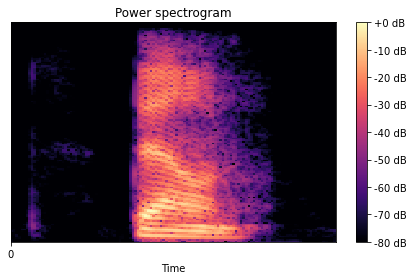

In [18]:
import matplotlib.pyplot as plt
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

```
 wav     ->  spectorgram
(8000, ) -> (130, 126)형태로 변환

train data   :  (45558, 8000)      -> (45558,130, 126)
train labels :  (45558,)           -> (45558,) 
test data    :  (5062, 8000)       -> (5062, 130, 126)
test labels  :  (5062,)            -> (5062,)

train_wav
train_label
test_wav
test_label

위와 같은 형태로 4개의 데이터가 변형돼어야된다.

```

# train_wav -> train_spec

In [11]:
#wav2spec함수 spectrogram shape을 맞추기위해서 size 변형


tmp = []
#print(train_wav[0].shape) # 출력(8000,)

for data in train_wav:  # data은 45558개로 (8000,)형태이다.
    spec = wav2spec(data)
    tmp.append(spec)
    
train_spec= np.array(tmp)
    
train_spec.shape



(45558, 130, 126)

#### train_wav는 train_spec 설정하기위한것이 때문에 지워주자  

In [12]:
del train_wav 

# test_wav -> test_spec




In [13]:
#wav2spec함수 spectrogram shape을 맞추기위해서 size 변형


tmp = []
#print(test_wav[0].shape) # 출력(8000)

for data in test_wav:  # wav은 45558개로 (8000)형태이다.
    spec = wav2spec(data)
    tmp.append(spec)
test_spec= np.array(tmp)
    
test_spec.shape


(5062, 130, 126)

#### test_wav는 test_spec 설정하기위한것이 때문에 지워주자 

In [14]:
del test_wav

In [15]:
# 위에서 뽑았던  data (5-2음성과 오디오 데이터)
#data = speech_data["wav_vals"][rand]
# 

print("Waveform shape : ",train_spec.shape)
print("Spectrogram shape : ",test_spec.shape)


Waveform shape :  (45558, 130, 126)
Spectrogram shape :  (5062, 130, 126)


### 라벨은 따로 변경해줄 필요가없다 우리는 특징(feature)만 1차원에서 2차원으로 변경했기때문에

# 2.Hyper-parameters setting

```
학습을 위한 하이퍼파라미터를 설정
batch_size = 32
max_epochs = 10

모델 체크포인트 저장을 위한 체크포인트의 경로를 설정
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec'
```


In [16]:
batch_size = 32
max_epochs = 10

# the save point
checkpoint_dir01 = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec' # 기본모델

#모델 체크포인트 Callback 함수를 설정하거나, 모델을 불러올때 사용합니다.
print(checkpoint_dir01)


/home/aiffel-dj60/aiffel/speech_recognition/models/spec


# 3. 데이터셋 구성

#### 원핫인코딩 함수 만들기
```  
'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence'의 12개의 단어를 표현하기 위해 depth=12개 설정

```


In [17]:
# 원핫인코딩 
# 텍스트를 [0,0,0,0,0,1,0,0,0,0,0,0] 꼴로 변경하기 위한 함수
def one_hot_label(spec, label):
    label = tf.one_hot(label, depth=12) # 12개인 이유는 12단어 이기때문에
    return spec, label
print("✅")

✅


### tf.data.Dataset 활용하기 (정확히 뭐하는지 모르겠음)

```
    
tf.data.Dataset는 Tensorflow에 포함된 이 데이터셋 관리 패키지이다.
데이터셋 전처리, 배치처리 등을 쉽게 할 수 있도록 해 줍니다


 train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label)) 
 -> (data,lebel)형태로 넣는다.
    train_spec   : (45558, 130, 126)
    train_label  : (45558,)
    
 train_dataset = train_dataset.map(one_hot_label)
 -> 데이터 전처리과정(매핑과정)을 one_hot_label함수로 설정한다라는 의미같다.(정확x)

 train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
 -> 배치사이즈 결정?, 나중에 다시 공부하자.
  
 <BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
 [정확하지않음] train은 130,126의 feature로 구성되고, 라벨은 12개의 클래스가 있다는 의미인것 같다
 
 train_dataset와 test_dataset의 타입은
 <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
 
```

In [18]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print("뭔 의미데?",test_dataset)
print("✅")
#print(type(test_dataset))
#print(type(test_dataset))

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
뭔 의미데? <BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
✅


ㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁ   
map과 batch를 이용한 데이터 전처리( 메모리 부족 현상 주의! )   
wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워주자.   
del speech_data / del spec_data    
ㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁ   

# 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성

```        

Audio 데이터는 1차원 데이터이기 때문에 데이터 형식에 맞도록 모델을 구성해주어야 합니다.
Conv1D layer를 이용해서 모델을 구성해보겠습니다.    
Conv, batch norm, dropout, dense layer 등을 이용해 모델을 구성해보도록 하죠.   

```

# 기본모델

In [19]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126)) #(130,126)

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model01_spec = tf.keras.Model(input_tensor, output_tensor)

model01_spec.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 130, 32)           36320     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 64)            18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)            0     

### Loss
```
- 현재 라벨이 될 수 있는 12개의 단어 class 
- 해당 class를 구분하기 위해서는 multi-class classification이 필요하며, 
  이를 수행하기 위한 Loss로 Categorical Cross-Entropy loss를 사용한다
```

In [20]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model01_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


### Training

### Callback (가중치 저장할수 있다.)
 - model.fit 함수를 이용할 때, callback 함수를 이용해서 학습 중간 중간 원하는 동작을 하도록 설정할 수 있습니다.
 - 모델을 재사용하기위해서 모델 가중치를 저장하는 callback 함수를 추가해보겠습니다.

```
현재 모델은 validation loss를 모니터하며, loss가 낮아지면 모델 파라미터를 저장하도록 구성되어 있습니다.

checkpoint_dir          : 체크포인트 경로
save_weights_only=True, : 가중치 저장 하겠느냐?
monitor='val_loss',     : 모니터 값을 어느것을 하겠느냐?
mode='auto',            : 자동모드?(몰라)
save_best_only=True,    : 세이브포인트는 가장 best할때
verbose=1               : 이건 멀까?

```

In [21]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir01,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


## fit 

-하이퍼파라미터 세팅에서 batch_size=32, max_epochs=10으로 세팅함  

-메모리가 부족하다면 batch_size를 작게 조절해 주는게 좋습니다.

In [22]:
# fit 훈련하기

#batch_size=32
#max_epochs=10

#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_spec01 = model01_spec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")


Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 1.3666 - accuracy: 0.5331
Epoch 00001: val_loss improved from inf to 0.83233, saving model to /home/aiffel-dj60/aiffel/speech_recognition/models/spec
1423/1423 [==============================] - 14s 10ms/step - loss: 1.3666 - accuracy: 0.5331 - val_loss: 0.8323 - val_accuracy: 0.7188
Epoch 2/10
1421/1423 [============================>.] - ETA: 0s - loss: 0.6976 - accuracy: 0.7653
Epoch 00002: val_loss improved from 0.83233 to 0.52972, saving model to /home/aiffel-dj60/aiffel/speech_recognition/models/spec
1423/1423 [==============================] - 14s 10ms/step - loss: 0.6974 - accuracy: 0.7653 - val_loss: 0.5297 - val_accuracy: 0.8234
Epoch 3/10
1418/1423 [============================>.] - ETA: 0s - loss: 0.4649 - accuracy: 0.8448
Epoch 00003: val_loss improved from 0.52972 to 0.41708, saving model to /home/aiffel-dj60/aiffel/speech_recognition/models/spec
1423/1423 [==============================] - 14s 10ms/st

# loss, accuracy를 그래프로 표현

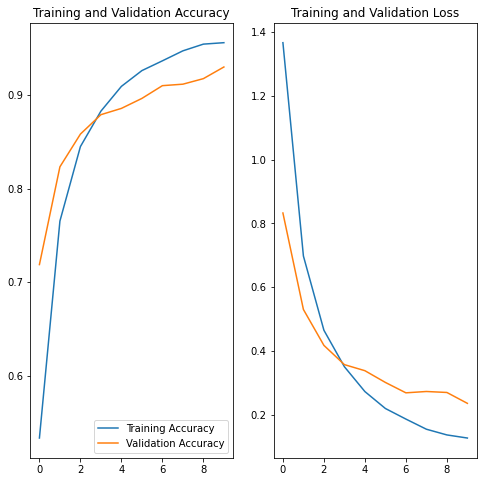

✅


In [23]:
import matplotlib.pyplot as plt

acc = history_spec01.history['accuracy']
val_acc = history_spec01.history['val_accuracy']

loss=history_spec01.history['loss']
val_loss=history_spec01.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.show()
print("✅")

### Evaluation

checkpoint callback 함수가 저장한 weight를 다시 불러온다.

In [24]:
model01_spec.load_weights(checkpoint_dir01)
print("✅")

✅


Test data을 이용하여 모델의 예측값과 실제값이 얼마나 일치 확인해보자

In [25]:
results = model01_spec.evaluate(test_dataset)
print("✅")

159/159 [==============================] - 18s 112ms/step - loss: 0.2350 - accuracy: 0.9303
✅


In [26]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 0.235
accuracy value: 93.0265%
✅


# Model Test

Test data 셋을 골라 직접 들어보고 모델의 예측이 맞는지 확인해 봅시다.   

```
test_spec[batch_index]       0 ~ 5062  
batch_xs.shape               (1, 130, 126)
``


In [43]:
inv_label_value = {v: k for k, v in label_value.items()}
print('inv_label_value 타입 :',type(inv_label_value))
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

print(batch_index)
batch_xs = test_spec[batch_index]
print(batch_xs.shape)
batch_ys = test_label[batch_index]
print(batch_ys.shape)

#y_pred_ = model01_spec(batch_xs, training=False)

#print("label : ", str(inv_label_value[batch_ys[0]]))

#ipd.Audio(batch_xs.reshape(130,126), rate=8000)

inv_label_value 타입 : <class 'dict'>
[2091]
(1, 130, 126)
(1,)


In [ ]:

(5062, 130, 126

위에서 확인해본 테스트셋의 라벨과 우리 모델의 실제 prediction 결과를 비교해 봅시다.

In [ ]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

# Skip-Connection model


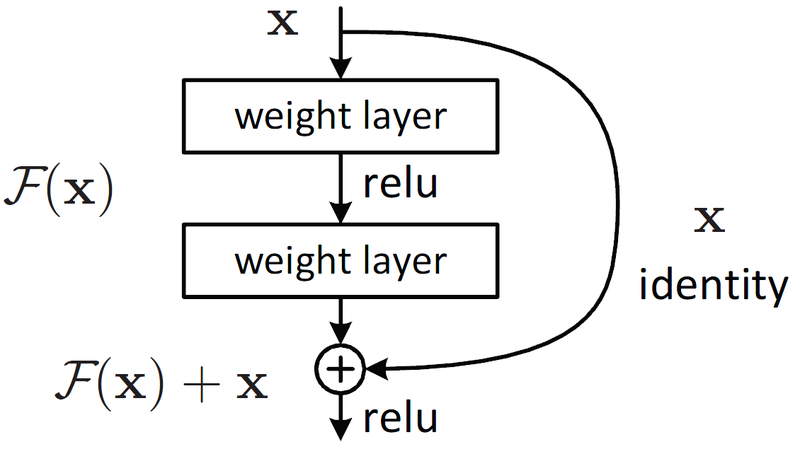

우리가 사용하는 데이터가 1차원 audio 데이터이기 때문에 1차원 데이터를 처리하는 모델을 구성해보겠습니다.

In [45]:
input_tensor = layers.Input(shape=(130, 126)) #(130,126)

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec_skip = tf.keras.Model(input_tensor, output_tensor)

model_spec_skip.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 130, 126)]   0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 130, 32)      36320       input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 130, 32)      9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 65, 32)       0           conv1d_11[0][0]                  
____________________________________________________________________________________________

모델 구성만 달라졌을 뿐, 그 외 Task구성이나 데이터셋 구성, 훈련 과정은 동일합니다

### loss

In [46]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


### train
### callback

In [47]:
# the save point
checkpoint_dir02 = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir02,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


### fit

In [48]:
#30분 내외 소요
history_spec_skip = model_spec_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
1421/1423 [============================>.] - ETA: 0s - loss: 1.5038 - accuracy: 0.4900
Epoch 00001: val_loss improved from inf to 0.99416, saving model to /home/aiffel-dj60/aiffel/speech_recognition/models/spec_skip
1423/1423 [==============================] - 34s 24ms/step - loss: 1.5031 - accuracy: 0.4902 - val_loss: 0.9942 - val_accuracy: 0.6669
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.7763 - accuracy: 0.7392
Epoch 00002: val_loss improved from 0.99416 to 0.55115, saving model to /home/aiffel-dj60/aiffel/speech_recognition/models/spec_skip
1423/1423 [==============================] - 33s 24ms/step - loss: 0.7763 - accuracy: 0.7392 - val_loss: 0.5511 - val_accuracy: 0.8174
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.4994 - accuracy: 0.8333
Epoch 00003: val_loss improved from 0.55115 to 0.44113, saving model to /home/aiffel-dj60/aiffel/speech_recognition/models/spec_skip
1423/1423 [==============================

# loss, accuracy를 그래프로 표현

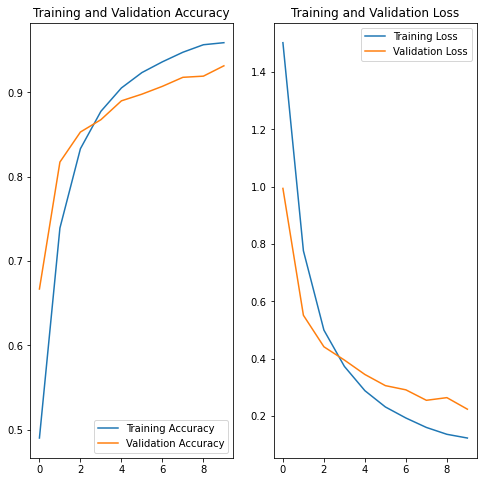

✅


In [49]:
import matplotlib.pyplot as plt

acc = history_spec_skip.history['accuracy']
val_acc = history_spec_skip.history['val_accuracy']

loss=history_spec_skip.history['loss']
val_loss=history_spec_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

### Evaluation

checkpoint callback 함수가 저장한 weight를 다시 불러온다.

In [50]:
# Evaluation 

model_spec_skip.load_weights(checkpoint_dir02)
results02 = model_spec_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results02[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results02[1]*100))
print("✅")

159/159 [==============================] - 17s 106ms/step - loss: 0.2230 - accuracy: 0.9316
loss value: 0.223
accuracy value: 93.1648%
✅


위에서 확인해본 테스트셋의 라벨과 우리 모델의 실제 prediction 결과를 비교해 봅시다.

기본모델    
loss value: 0.235    
accuracy value: 93.0265%    
   
   
Skip-Connection 모델    
loss value: 0.223   
accuracy value: 93.1648%   

# 질문
### 1.speech_data["label_vals"].shape 은 (50620,1)로 표현되는건가?    
-> 1이라는것은 ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go' ] 표현한다. 
 -> reshape때문에 1이 추가된것이다 위에 말 틀림

### 2.다운로드 파일은 sample rate가 16000이라는데 8000인것인가? re-sampling이 적용된 파일인것인가?

### 3. train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN 왜?????
-> (8000, )차원을  (8000, 1)차원으로 변경한다.   
-> cnn는 3차원(세로,가로,채널)    
https://excelsior-cjh.tistory.com/180
https://m.blog.naver.com/PostView.nhn?blogId=jsky10503&logNo=221325535776&proxyReferer=https:%2F%2Fwww.google.com%2F    
-> Spectrogram으로 변경시 3차원이 구성되기때문에 reshape를 할 필요없다.

### 4. <BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>의미는? 






# 질문
### 1.speech_data["label_vals"].shape 은 (50620,1)로 표현되는건가?    
 -> [틀림]1이라는것은 ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go' ] 표현한다.  
 -> reshape때문에 차원이 추가된것이다 

### 2.다운로드 파일은 sample rate가 16000이라는데 8000인것인가? re-sampling이 적용된 파일인것인가?

### 3. train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN 왜?????
-> (8000, )차원을  (8000, 1)차원으로 변경한다.   
-> cnn는 3차원(세로,가로,채널)    
https://excelsior-cjh.tistory.com/180
https://m.blog.naver.com/PostView.nhn?blogId=jsky10503&logNo=221325535776&proxyReferer=https:%2F%2Fwww.google.com%2F    
-> Spectrogram으로 변경시 3차원이 구성되기때문에 reshape를 할 필요없다.


### 4. <BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>의미는? 

### 5. (8000, ) 와 (8000, 1) 같은 의미인가?

참고 사이트 
```
numpy.reshape 함수 (배열과 차원을 변형) : https://blog.naver.com/navehag/222216294457
for enumerate                      : https://blog.naver.com/navehag/222216242194
원핫인코딩이란( tf.one_hot)           : https://blog.naver.com/navehag/222216723519
                                     https://www.tensorflow.org/guide/data
```
